In [1]:
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


c:\Users\assi01\Desktop\projects\AirTravel_Sentiment_Analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pwd

'c:\\Users\\assi01\\Desktop\\projects\\AirTravel_Sentiment_Analysis\\research'

In [3]:
os.chdir('../')

In [4]:
%pwd

'c:\\Users\\assi01\\Desktop\\projects\\AirTravel_Sentiment_Analysis'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=False)
class DataProcessingConfig:
    root_dir: Path
    raw_data_file: str
    train_data_path: Path
    test_data_path: Path
    val_data_path: Path
    params_test_size: float
    params_label_col: str
    params_text_col: str
    params_random_state: int

In [6]:
from airTravelSentimentAnalysis.constants import *
from airTravelSentimentAnalysis.utils.common import read_yaml, create_directories


In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_data_processing_config(self) -> DataProcessingConfig:
        config = self.config.data_preprocessing

        create_directories([config.root_dir])

        data_processing_config = DataProcessingConfig(
            root_dir=Path(config.root_dir),
            raw_data_file=config.raw_data_file,
            train_data_path=Path(config.train_data_path),
            test_data_path=Path(config.test_data_path),
            val_data_path=Path(config.val_data_path),
            params_test_size=self.params.TEST_SIZE,
            params_label_col= self.params.LABEL_COL,
            params_text_col= self.params.TEXT_COL,
            params_random_state = self.params.RANDOM_STATE,
        )

        return data_processing_config

In [8]:
import pandas as pd

In [9]:
from airTravelSentimentAnalysis import logger
from sklearn.model_selection import train_test_split

In [10]:
class DataProcessing:
    def __init__(self, config: DataProcessingConfig):
        self.config = config

    
    def loadData(self):
        self.df = pd.read_csv( self.config.raw_data_file, encoding='utf-8')
        return self.df
    
    def eda(self):
        # Display the first few rows of the DataFrame
        logger.info("\n \n %s",self.df.head())

        logger.info("Unique value count of intent: \n %s",self.df[self.config.params_label_col].value_counts())
        
        # Display the shape of the DataFrame
        logger.info("Shape of the DataFrame:\n %s",self.df.shape)
        
        # Display the number of unique values in each column        
        logger.info("Unique values: \n %s",self.df.nunique())

        # Display basic statistics for numerical columns
        logger.info("Basic statistics:\n %s",self.df.describe())

        # Display the number of missing values in each column
        logger.info("Missing values:\n %s",self.df.isnull().sum())

        # Display the unique values in the 'intent' column
        logger.info("Unique intents: \n %s",self.df[self.config.params_label_col].unique())
        
        
        self.barGraph()
        self.radialGraph()
        return self.df
        
    
    def barGraph(self): 
        sns.countplot(self.df, x=self.config.params_label_col,hue=self.config.params_label_col)
        plt.xticks(rotation=90)
        plt.show()
    
    def radialGraph(self): 
        targetCounts = self.df[self.config.params_label_col].value_counts()
        targetLabels  = targetCounts.index
        # Make square figures and axes
        plt.figure(1, figsize=(25,25))
        the_grid = GridSpec(2, 2)
        cmap = plt.get_cmap('coolwarm')
        colors = [cmap(i) for i in np.linspace(0, 1, len(targetLabels))]
        plt.subplot(the_grid[0, 1], aspect=1)

        plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
        plt.title('Intent Distribution', fontsize=20)

        plt.show()
        
    
    def preProcessData(self):
        # Drop duplicates
        # self.df = self.df.drop_duplicates()

        # Drop null values
        self.df = self.df.dropna()

        self.df[self.config.params_label_col] = self.df[self.config.params_label_col].str.lower().str.strip().replace('_', ' ')
        # self.df[config.params_text_col] =  self.df[self.config.params_text_col].apply(self.cleanInstruction)
        return self.df
    
    def cleanInstruction(instructionText):
        # Remove URLs
        instructionText = re.sub(r'http\S+|www\S+|https\S+', '', instructionText)
        # Remove RT | cc
        instructionText = re.sub(r'RT|cc', '', instructionText)
        # Remove hashtags and mentions
        instructionText = re.sub(r'(@|#)\S+', '', instructionText)
        # Remove punctuations
        instructionText = instructionText.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        instructionText = re.sub(r'\s+', ' ', instructionText).strip()
        return instructionText
    
    def removeExtraColumns(self):
        # Remove extra columns
        self.df = df[[self.config.params_text_col,self.config.params_label_col]]
        return self.df
    
    def labelEncoding(self):
        # Label Encoding
        le = LabelEncoder()
        copydf = self.df.copy()
        copydf[self.config.params_label_col] = le.fit_transform(copydf[self.config.params_label_col])
        self.df = copydf
        return self.df
    
    def splitData(self):
        # Split the data into train, validation, and test sets
        df = self.df.copy()
        train_test_df, val_df = train_test_split(df, test_size=self.config.params_test_size, stratify=df[self.config.params_label_col], random_state=self.config.params_random_state)
        train_df, test_df = train_test_split(train_test_df, test_size=self.config.params_test_size, stratify=train_test_df[self.config.params_label_col], random_state=self.config.params_random_state)
        logger.info("Length of train dataframe: \n %s",len(train_df))
        logger.info("Length of test dataframe: \n %s",len(test_df))
        logger.info("Length of val dataframe: \n %s",len(val_df))
        train_df.to_csv(self.config.train_data_path, index=False, header=True, encoding='utf-8')
        test_df.to_csv(self.config.test_data_path, index=False, header=True, encoding='utf-8')
        val_df.to_csv(self.config.val_data_path, index=False, header=True, encoding='utf-8')
    
    

[2025-05-22 18:22:44,600: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-22 18:22:44,602: INFO: common: yaml file content: {'artifacts_root': 'artifacts', 'data_ingestion': {'root_dir': 'artifacts/data_ingestion', 'source_URL': 'https://drive.google.com/file/d/1taIeW6BZHqucmJbccEo92qfzZt5X_RTQ/view?usp=sharing', 'local_data_file': 'artifacts/data_ingestion/data.zip', 'unzip_dir': 'artifacts/data_ingestion'}, 'prepare_base_model': {'root_dir': 'artifacts/prepare_base_model', 'base_model_path': 'artifacts/prepare_base_model/base_model.h5', 'updated_base_model_path': 'artifacts/prepare_base_model/base_model_updated.h5', 'base_tokenizer_path': 'artifacts/prepare_base_tokenizer/base_model.h5', 'updated_base_tokenizer_path': 'artifacts/prepare_base_tokenizer/base_model_updated.h5'}, 'data_preprocessing': {'root_dir': 'artifacts/data_preprocessing', 'raw_data_file': 'artifacts/data_ingestion/bitext-travel-llm-chatbot-training-dataset.csv', 'train_data_path': 'artifa

Data loaded successfully
                     instruction             intent category     tags  \
count                      31658              31658    31658    31658   
unique                     30751                 33       11      362   
top     The original instruction  check_trip_prices   FLIGHT  BCILPQZ   
freq                          35               1874    10619      847   

                                                 response  
count                                               31658  
unique                                              18673  
top     If you need to search for a trip, you can find...  
freq                                                   79  
[2025-05-22 18:22:44,904: INFO: 1355626752: Data loaded successfully 
                      instruction             intent category     tags  \
count                      31658              31658    31658    31658   
unique                     30751                 33       11      362   
top     The origina

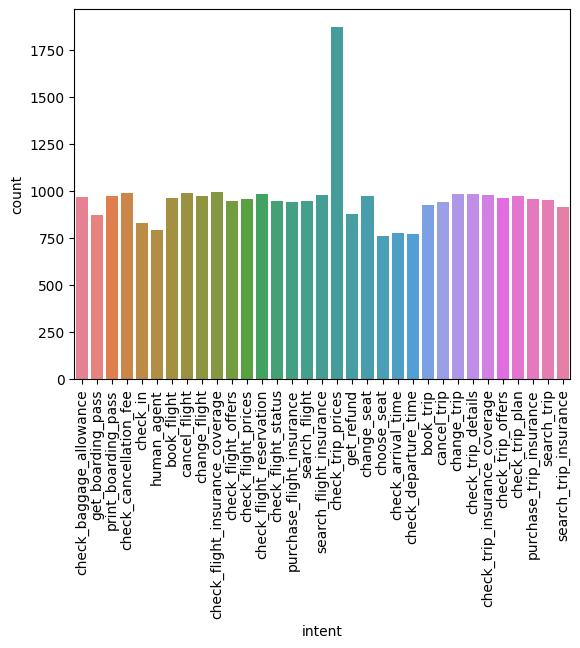

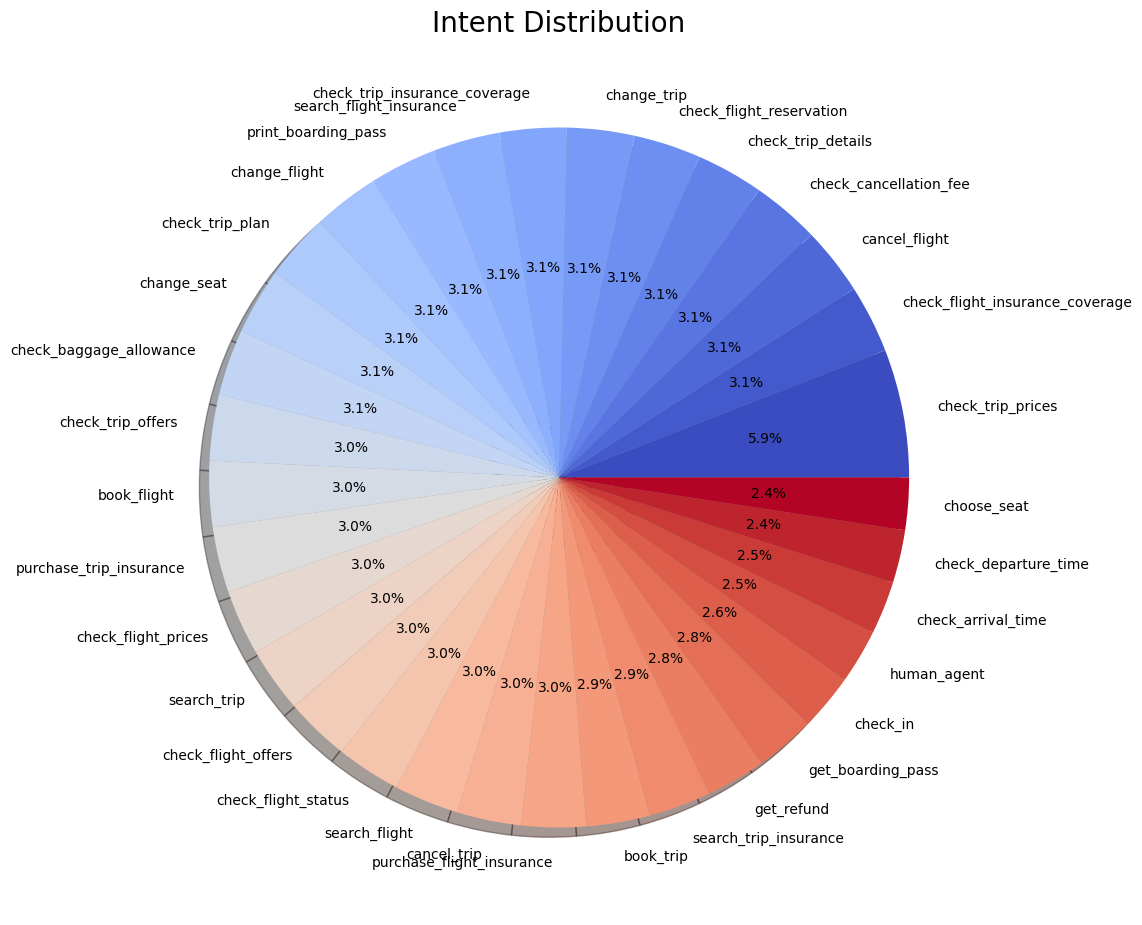

Data EDA processed successfully
                     instruction             intent category     tags  \
count                      31658              31658    31658    31658   
unique                     30751                 33       11      362   
top     The original instruction  check_trip_prices   FLIGHT  BCILPQZ   
freq                          35               1874    10619      847   

                                                 response  
count                                               31658  
unique                                              18673  
top     If you need to search for a trip, you can find...  
freq                                                   79  
[2025-05-22 18:22:45,614: INFO: 1355626752: Data EDA processed successfully 
                      instruction             intent category     tags  \
count                      31658              31658    31658    31658   
unique                     30751                 33       11      362   
top  

In [11]:
try:
    config = ConfigurationManager()
    data_processing_config = config.get_data_processing_config()
    data_processing = DataProcessing(config=data_processing_config)
    df = data_processing.loadData()
    print("Data loaded successfully")
    print(df.describe())
    logger.info("Data loaded successfully \n %s",df.describe())
    df = data_processing.eda()
    print("Data EDA processed successfully")
    print(df.describe())
    logger.info("Data EDA processed successfully \n %s",df.describe())
    df = data_processing.preProcessData()
    print("Data preprocessed successfully")
    print(df.describe())
    logger.info("Data preprocessed successfully \n %s",df.describe())
    df = data_processing.labelEncoding()
    print("Label encoded successfully")
    print(df.head())
    logger.info("Label encoded successfully \n %s",df.head())
    df = data_processing.removeExtraColumns()
    print("Removed Extra columns successfully")
    print(df.head())
    logger.info("Removed Extra columns successfully \n %s",df.head())
    data_processing.splitData()
except Exception as e:
    raise e

In [ ]:
from transformers import BertTokenizer
import pandas as pd

class TextPreprocessor:
    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.max_length = max_length
        
    def tokenize_fn(self,batch):
        return self.tokenizer(batch["instruction"], truncation=True,padding=True)

    def preprocess_text(self, text):
        """
        Optionally clean text if needed (e.g., remove emojis, lowercasing).
        BERT does not need lowercasing if using 'uncased' model.
        """
        return text.strip()

    def encode(self, texts, labels=None):
        """
        Tokenize and encode a list of texts into model input format.
        """
        cleaned_texts = [self.preprocess_text(t) for t in texts]

        encodings = self.tokenizer(
            cleaned_texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        if labels is not None:
            encodings['labels'] = labels

        return encodings

In [ ]:
texts = ["This is great!", "BERT is awesome for NLP."]
labels = [1, 1]

preprocessor = TextPreprocessor(model_name="bert-base-uncased", max_length=64)
inputs = preprocessor.encode(texts, labels=labels)

print(inputs.keys())

c:\Users\assi01\Desktop\projects\AirTravel_Sentiment_Analysis\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\assi01\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
